# Import Required Libraries
Import TensorFlow, NumPy, SciPy, Matplotlib, and other necessary libraries.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Required Libraries

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import time

from lib.Pre.FNN import FNN
from lib.Pre.PINN import PINN
from lib.Pre.L_BFGS_B import L_BFGS_B
#from lib.Pre_Process import Pre_Process
#from lib.Train import Train
#from lib.Post_Process import Post_Process

# Define Pre-Processing Function
Define the Pre_Process function to initialize the geometry, material properties, boundary conditions, neural networks, and optimizer.

In [3]:
import math
def Input_Info():
    """
    ====================================================================================================================

    This function is to load the problem information, including:
        1. Define the problem geometry;
        2. Define the material property;
        3. Define the boundary condition;
        4. Define the FNN settings.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [ns]        [int]                   : Total number of sample points;
    [dx]        [float]                 : Sample points interval;
    [xy]        [Array of float32]      : Coordinates of all the sample points;
    [xy_u]      [Array of float32]      : Coordinates of the sample points on the upper boundary of the plate;
    [xy_b]      [Array of float32]      : Coordinates of the sample points on the bottom boundary of the plate;
    [xy_l]      [Array of float32]      : Coordinates of the sample points on the left boundary of the plate;
    [xy_r]      [Array of float32]      : Coordinates of the sample points on the right boundary of the plate;
    [x_train]   [List]                  : PINN input list, contains all the coordinates information;
    [s_u_x]     [Array of float32]      : x direction traction boundary condition on the top boundary of the plate;
    [s_u_y]     [Array of float32]      : y direction traction boundary condition on the top boundary of the plate;
    [s_b_x]     [Array of float32]      : x direction traction boundary condition on the bottom boundary of the plate;
    [s_b_y]     [Array of float32]      : y direction traction boundary condition on the bottom boundary of the plate;
    [s_l_x]     [Array of float32]      : x direction traction boundary condition on the left boundary of the plate;
    [s_l_y]     [Array of float32]      : y direction traction boundary condition on the left boundary of the plate;
    [s_r_x]     [Array of float32]      : x direction traction boundary condition on the right boundary of the plate;
    [s_r_y]     [Array of float32]      : y direction traction boundary condition on the right boundary of the plate;
    [y_train]   [List]                  : PINN boundary condition list, contains the traction boundary condition;
    [n_input]   [int]                   : Number of inputs for the FNN;
    [n_output]  [int]                   : Number of outputs for the FNN;
    [layers]    [list]                  : Size of the FNN;
    [acti_fun]  [str]                   : The activation function used after each layer;
                                                        Available options:
                                                        'tanh'
                                                        'sigmoid'
                                                        'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
    [k_init]    [str]                   : The kernel initialisation method.
    [NN_info]   [list]                  : Neural Network information list, contains the settings for the FNN;
    [E]         [float]                 : Young's module;
    [mu]        [float]                 : Poisson ratio.

    ====================================================================================================================
    """
    
    ### Define the number of sample points
    ns_u = 51
    ns_l = 51
    ns = ns_u*ns_l
    
    ### Define the sample points' interval
    dx = 1./(ns_u-1)
    
    ### Initialize sample points' coordinates
    xy = np.zeros((ns, 2)).astype(np.float32)
    for i in range(0,ns_u):
        for j in range(0,ns_l):
            xy[i*ns_l+j, 0] = i * dx
            xy[i*ns_l+j, 1] = j * dx
    xy_u = np.hstack([np.linspace(0,1, ns_u).reshape(ns_u, 1).astype(np.float32), \
                      np.ones((ns_u,1)).astype(np.float32)])
    xy_b = np.hstack([np.linspace(0,1, ns_u).reshape(ns_u, 1).astype(np.float32), \
                      np.zeros((ns_u,1)).astype(np.float32)])
    xy_l = np.hstack([np.zeros((ns_l,1)).astype(np.float32), \
                  np.linspace(0,1, ns_l).reshape(ns_l, 1).astype(np.float32)])
    xy_r = np.hstack([np.ones((ns_l,1)).astype(np.float32), \
                  np.linspace(0,1, ns_l).reshape(ns_l, 1).astype(np.float32)])
    
    ### Create the PINN input list
    x_train = [ xy, xy_u, xy_b, xy_l, xy_r]
    
    ### Define the material properties
    E = 7.
    mu = 0.3
    
    ### Define the traction boundary conditions
    s_u_x = np.zeros((ns_u,1)).astype(np.float32)
    s_u_y = np.zeros((ns_u,1)).astype(np.float32)
    s_b_x = np.zeros((ns_u,1)).astype(np.float32)
    s_b_y = np.zeros((ns_u,1)).astype(np.float32)
    s_l_x = np.zeros((ns_l,1)).astype(np.float32)
    s_l_y = np.zeros((ns_l,1)).astype(np.float32)
    s_r_x = np.cos(xy_r[..., 1, np.newaxis]/2*math.pi)
    s_r_y = np.zeros((ns_l,1)).astype(np.float32)

    ### Create the PINN boundary condition list
    y_train = [ s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y ]
    
    ### Define the FNN settings
    n_input = 2
    n_output = 1
    layer = [[ 20, 20, 20 ],[ 20, 20, 20 ]]
    NN_info = [n_input, n_output, layer]
    
    print('*************************************************')
    print('Problem Info.')
    print('*************************************************\n')
    print(ns, 'sample points')
    print('The Young''s module is', E,'; The Possion''s ratio is', mu,'.\n')
    print('*************************************************')
    print('Neural Network Info.')
    print('*************************************************\n')
    print('net_u \nNumber of input:',n_input,', Number of output:',n_output,'.')
    print(len(layer[0]),'hidden layers,',layer[0][0],' neurons per layer.')
    print('net_v \nNumber of input:',n_input,', Number of output:',n_output,'.')
    print(len(layer[1]),'hidden layers,',layer[0][1],' neurons per layer.\n')
    print('*************************************************\n')
    return ns, ns_u, ns_l, x_train, y_train, E, mu, dx, NN_info

In [4]:
# Define Pre-Processing Function

def Pre_Process():
    """
    ====================================================================================================================

    Pre_Process function is to:
        1. Load the problem information;
        2. Build up the FNN;
        3. Build up the PINN;
        4. Initialize the L-BFGS-B optimiser.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [ns]        [int]                   : Total number of sample points;
    [ns_u]      [int]                   : Number of sample points on top boundary of the beam;
    [ns_l]      [int]                   : Number of sample points on left boundary of the beam;
    [dx]        [float]                 : Sample points interval;
    [x_train]   [List]                  : PINN input list, contains all the coordinates information;
    [y_train]   [List]                  : PINN boundary condition list, contains all the traction boundary conditions;
    [NN_info]   [list]                  : Neural Network information list, contains the settings for the FNN;
    [E]         [float]                 : Young's module;
    [mu]        [float]                 : Poisson ratio.
    [net_u]     [Keras model]           : The built FNN for displacement u;
    [net_v]     [Keras model]           : The built FNN for displacement v;
    [pinn]      [Keras model]           : The built PINN;
    [l_bfgs_b]  [class]                 : The initialised L-BFGS-B optimiser.

    ====================================================================================================================
    """
    
    ### Input information
    ns, ns_u, ns_l, x_train, y_train, E, mu, dx, NN_info = Input_Info()
 
    ### Initialize the Feedforward Neural Networks
    net_u = FNN(n_input = NN_info[0], n_output = NN_info[1], layers = NN_info[2][0])
    
    net_v = FNN(n_input = NN_info[0], n_output = NN_info[1], layers = NN_info[2][1])
    
    ### Initialize the Physics-informed Neural Network
    pinn = PINN(net_u, net_v, E, mu)
    
    ### Initialize the L-BFGS-B optimizer
    l_bfgs_b = L_BFGS_B(pinn, x_train, y_train, dx)
    
    return net_u, net_v, pinn, l_bfgs_b

# Define Training Function
Define the Train function to train the PINN with the selected optimizer.

In [5]:
# Define Training Function

def Train(l_bfgs_b):
    """
    ====================================================================================================================

    Train function is to train the neural networks with the selected optimizer.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [result]    [tuple]                 : The result returned by the optimiser;
    [his_loss]  [list]                  : History values of the loss terms;
    [t]         [float]                 : CPU time used for training;
    [l]         [float]                 : Final loss;
    [it]        [int]                   : The number of iterations for convergence.

    ====================================================================================================================
    """

    time_start = time.time()
    hist, his_loss = l_bfgs_b.fit()
    time_end = time.time()
    
    T = time_end - time_start
    L = hist[1]
    it = hist[2]['funcalls']
    
    print('*************************************************\n')
    print('Time cost is', T, 's')
    print('Final loss is', L, '')
    print('Training converges by', it, 'iterations\n')
    print('*************************************************\n')
    
    return T, L, it, his_loss

# Define Post-Processing Function
Define the Post_Process function to visualize the predicted field variables and output results.

In [6]:
# Define Post-Processing Function

def Post_Process(net_u, net_v, pinn, his_loss):
    """
    ====================================================================================================================

    Post_Process function is to:
        1. Visualize the displacement, strain, and stress;
        2. Output results.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.
    
    [xy]        [array of float]        : Coordinates of all the sample points;
    [u]         [array of float]        : Displacement in x direction;
    [v]         [array of float]        : Displacement in y direction;
    [s11]       [array of float]        : Normal Stress in x direction;
    [s22]       [array of float]        : Normal Stress in y direction;
    [s12]       [array of float]        : Shear Stress on xy plane;
    [net_u]     [keras model]           : The trained FNN for displacement u;
    [net_v]     [keras model]           : The trained FNN for displacement v;
    [pinn]      [Keras model]           : The Physics-Informed Neural Network;
    [his_loss]  [list]                  : History values of the loss terms.

    ====================================================================================================================
    """

    xy = np.zeros((201*201, 2)).astype(np.float32)
    k = 0
    for i in range(0, 201):
        for j in range(0, 201):
            xy[k, 0] = i * 1/200
            xy[k, 1] = j * 1/200
            k = k + 1
    
    u = net_u.predict(xy) * xy[..., 0, np.newaxis]
    v = net_v.predict(xy) * xy[..., 1, np.newaxis]
    temp = pinn.predict([xy for i in range(0, 5)])
    s11 = temp[3]
    s22 = temp[4]
    s12 = temp[5]

    ### plot figure for displacement u
    fig1 = plt.figure(1)
    plt.scatter(xy[:, 0], xy[:, 1], s = 5, c = u, cmap = 'jet', vmin = 0, vmax = 0.15)
    plt.axis('equal')
    plt.colorbar()
    plt.title('u')
    plt.savefig('u.tiff', dpi = 600)
    
    ### plot figure for displacement v
    fig2 = plt.figure(2)
    plt.scatter(xy[:, 0], xy[:, 1], s = 5, c = v, cmap = 'jet', vmin = -4e-2, vmax = 0)
    plt.axis('equal')
    plt.colorbar()
    plt.title('v')
    plt.savefig('v.tiff', dpi = 600)
    
    ### plot figure for stress sigma_x
    fig3 = plt.figure(3)
    plt.scatter(xy[:, 0], xy[:, 1], s = 5, c = s11, cmap = 'jet', vmin = 0, vmax = 1)
    plt.axis('equal')
    plt.colorbar()
    plt.title(r'$\sigma_{x}$')
    plt.savefig('sigma_x.tiff', dpi = 600)
    
    ### plot figure for stress sigma_y
    fig4 = plt.figure(4)
    plt.scatter(xy[:, 0], xy[:, 1], s = 5, c = s22, cmap = 'jet', vmin = -0.1, vmax = 0.4)
    plt.axis('equal')
    plt.colorbar()
    plt.title(r'$\sigma_{y}$')
    plt.savefig('sigma_y.tiff', dpi = 600)
    
    ### plot figure for stress tau_xy
    fig5 = plt.figure(5)
    plt.scatter(xy[:, 0], xy[:, 1], s = 5, c = s12, cmap = 'jet', vmin = -0.1, vmax = 0)
    plt.axis('equal')
    plt.colorbar()
    plt.title(r'$\tau_{xy}$')
    plt.savefig('tau_xy.tiff', dpi = 600)
    
    ### plot figure for hist_loss
    fig6 = plt.figure(6, figsize=(3, 3), dpi = 600)
    plt.plot(his_loss[0], color = 'r')
    plt.plot(his_loss[1], color = 'b')
    plt.plot(his_loss[0] + his_loss[1], color = 'k')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend(['$L_{ge}$', '$L_{bc}$', 'L'])
    plt.savefig('hist_loss.tiff', dpi = 600, bbox_inches = 'tight')
    plt.show()
    
    ### output data in the 'out.mat' file
    scipy.io.savemat('out.mat', {'xy': xy, 'u': np.hstack([u, v]), 's11': s11, 's22': s22, 's12': s12}) 
    
    return None

# Execute Main Workflow
Execute the main workflow by calling Pre_Process, Train, and Post_Process functions.

*************************************************
Problem Info.
*************************************************

2601 sample points
The Youngs module is 7.0 ; The Possions ratio is 0.3 .

*************************************************
Neural Network Info.
*************************************************

net_u 
Number of input: 2 , Number of output: 1 .
3 hidden layers, 20  neurons per layer.
net_v 
Number of input: 2 , Number of output: 1 .
3 hidden layers, 20  neurons per layer.

*************************************************

Optimizer: L-BFGS-B (Provided by Scipy package)
Initializing ...
Iter: 10   L1 = 0.04128   L2 = 0.0709
Iter: 20   L1 = 0.03365   L2 = 0.0671
Iter: 30   L1 = 0.03412   L2 = 0.06792
Iter: 40   L1 = 0.03399   L2 = 0.06801
Iter: 50   L1 = 0.0343   L2 = 0.06843
Iter: 60   L1 = 0.03415   L2 = 0.06833
Iter: 70   L1 = 0.03428   L2 = 0.06847
Iter: 80   L1 = 0.03425   L2 = 0.06846
Iter: 90   L1 = 0.03412   L2 = 0.06836
Iter: 100   L1 = 0.03423   L2 = 0.06848
Ite

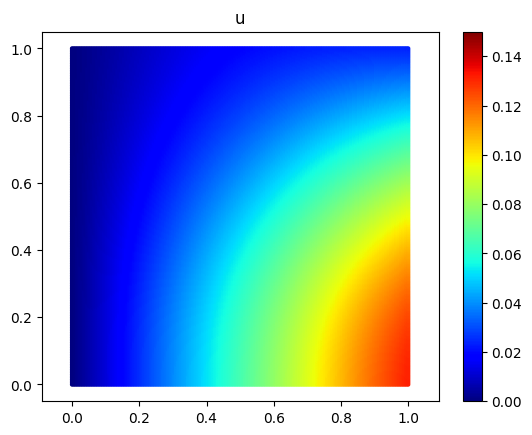

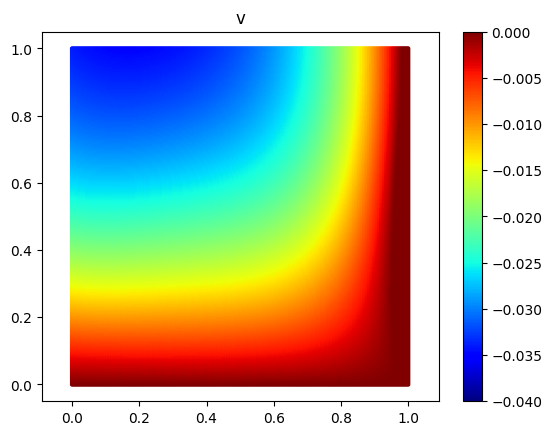

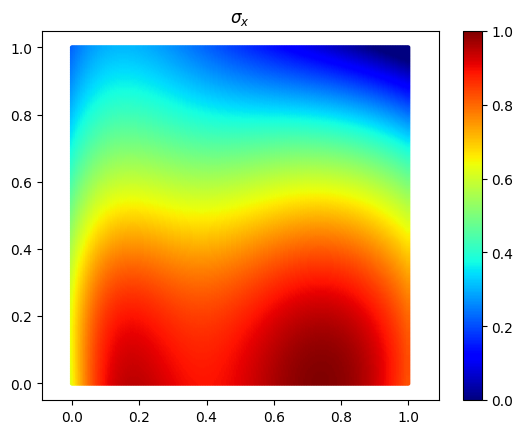

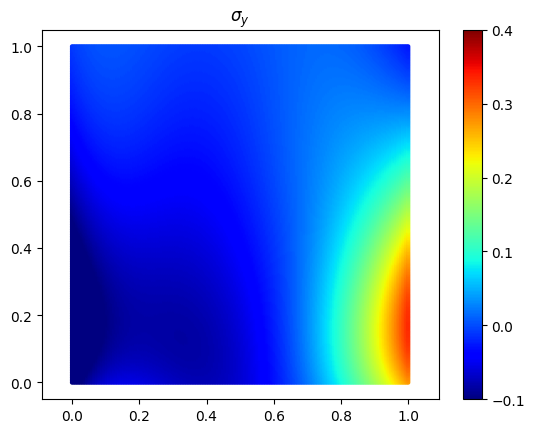

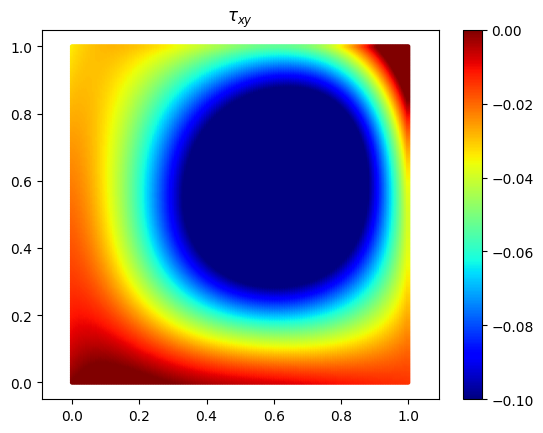

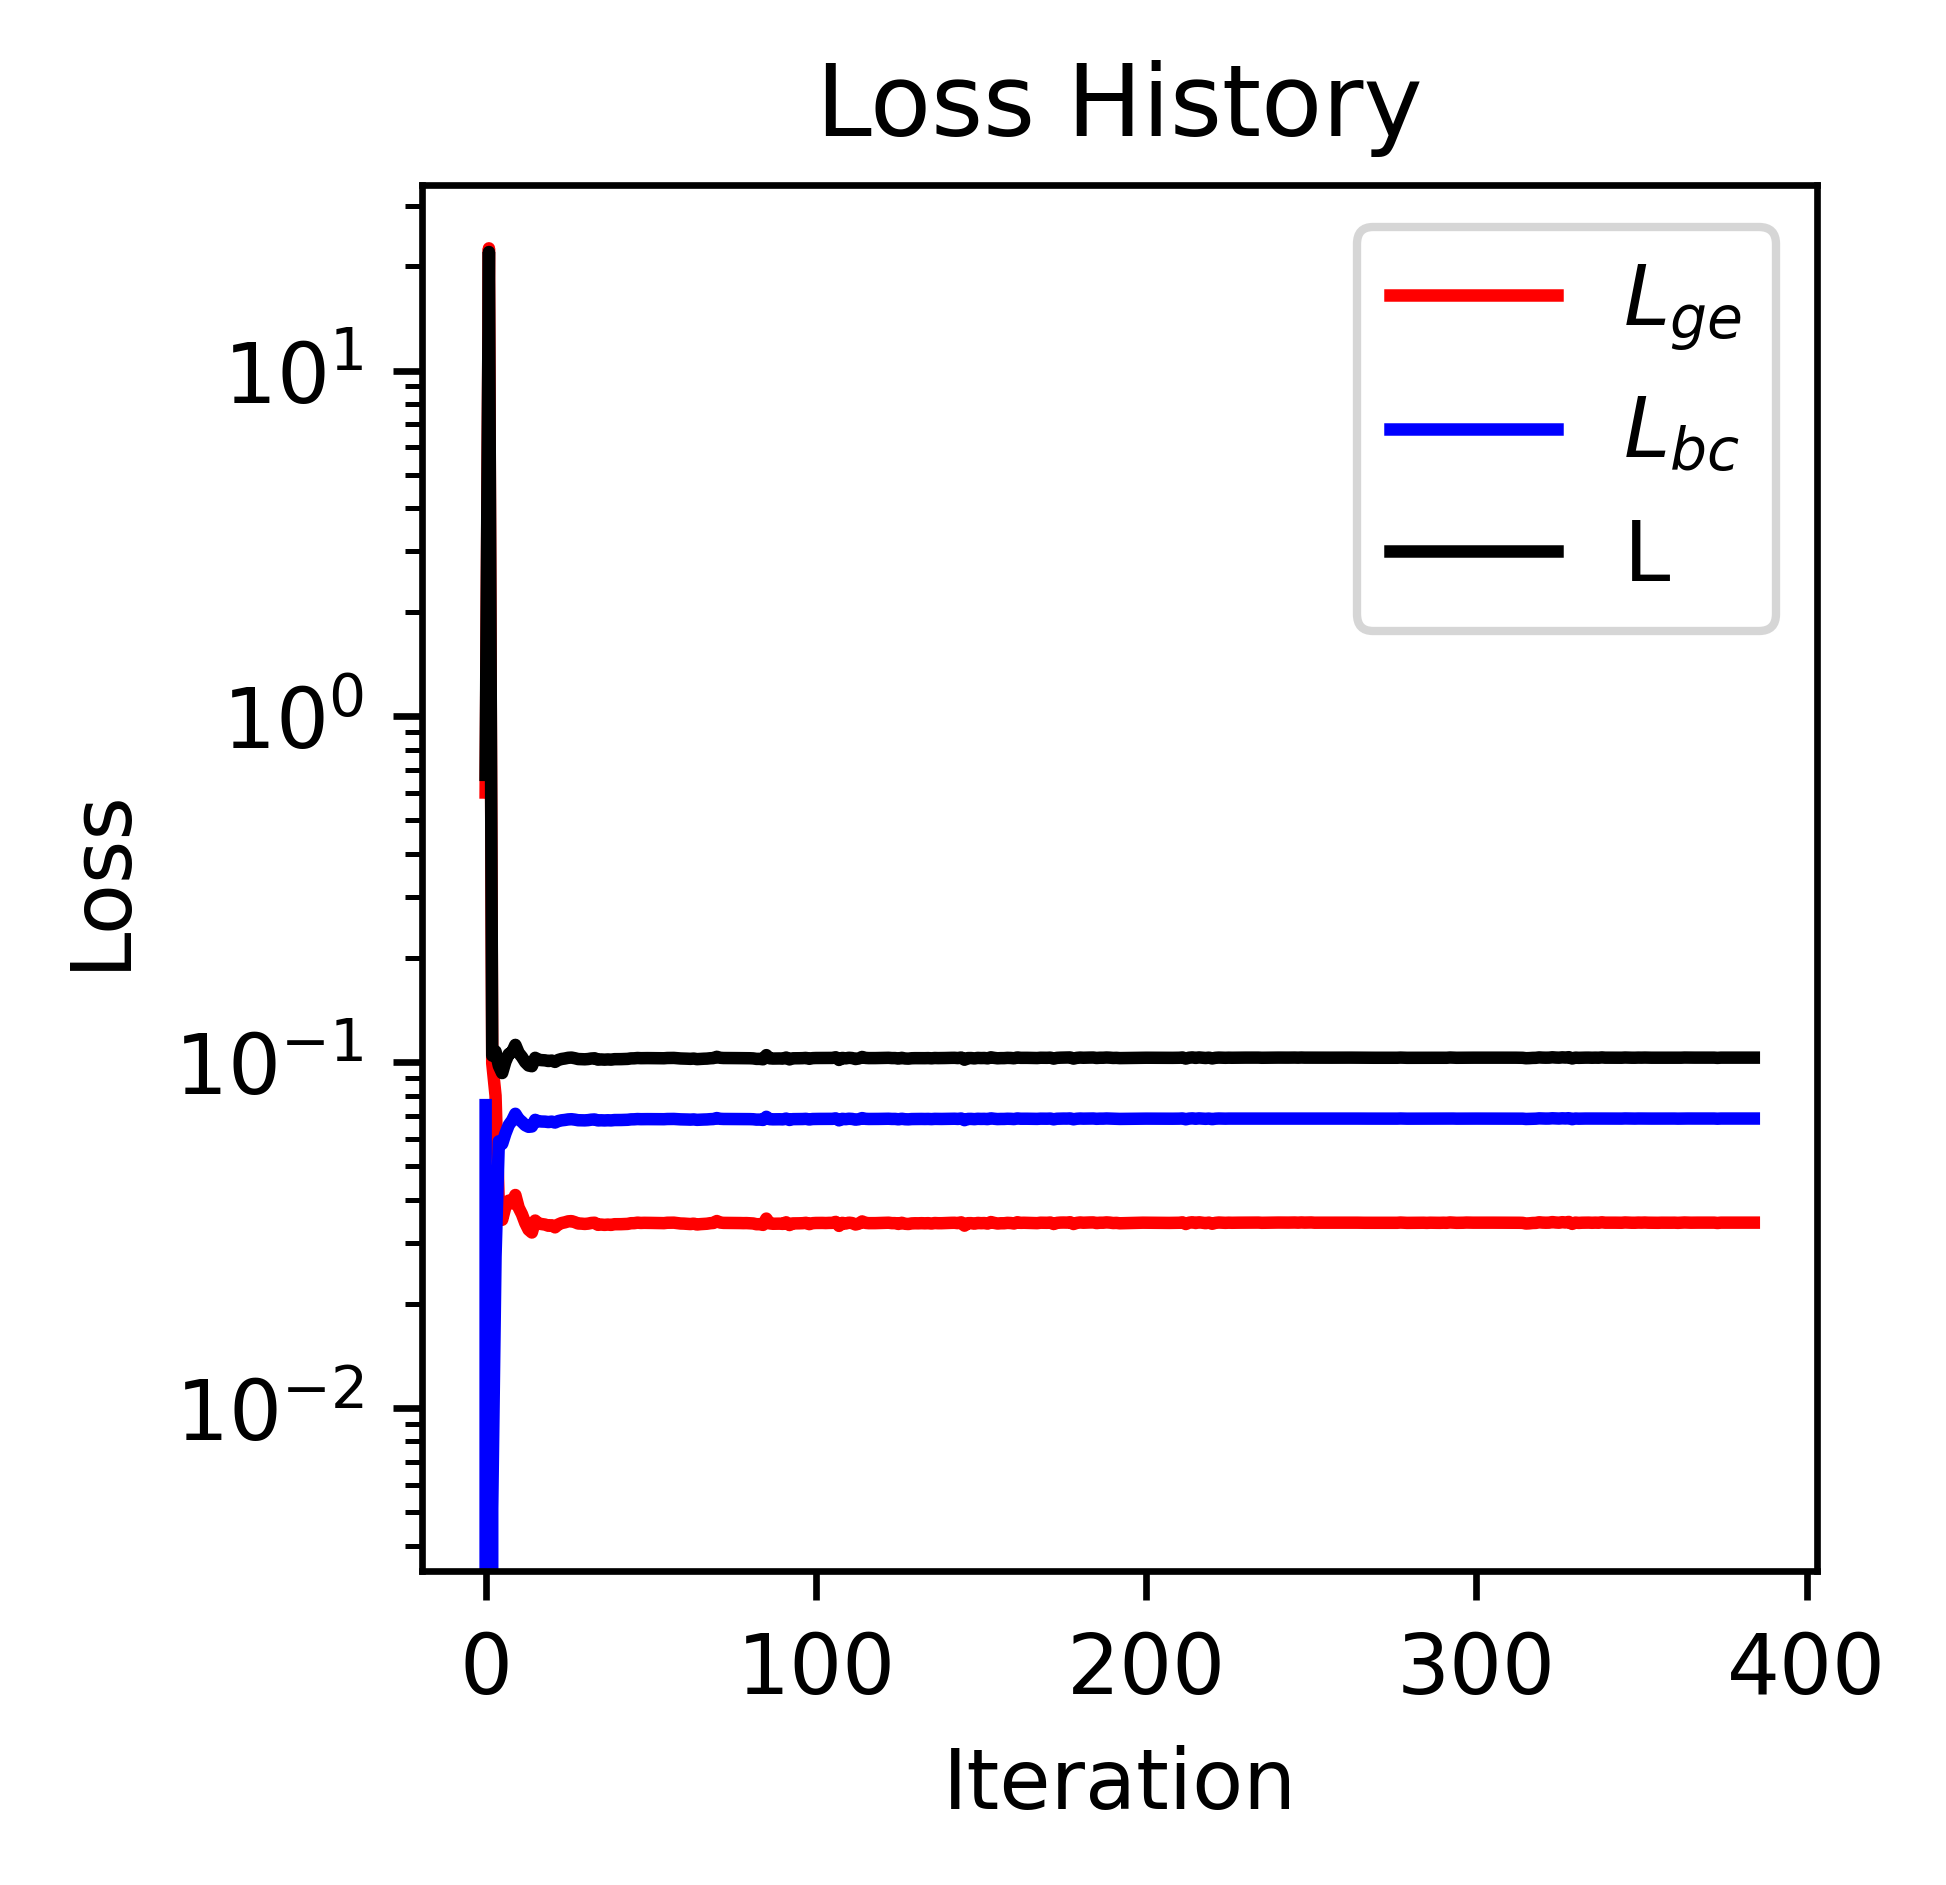

In [7]:
# Execute Main Workflow

# Execute the main workflow by calling Pre_Process, Train, and Post_Process functions
net_u, net_v, pinn, l_bfgs_b = Pre_Process()
T, L, it, his_loss = Train(l_bfgs_b)
Post_Process(net_u, net_v, pinn, his_loss)